In [95]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit
from matplotlib import pyplot as plt

In [96]:
v = 10000
d = 1000

alpha = 0.75
beta = 0.25

n_sims = 10

In [97]:
key = random.key(0)

b = jnp.power(jnp.arange(v*1.0)+1,-beta)
one = jnp.ones(shape=(d,))
c = 0

D_vec = jnp.power(jnp.arange(v*1.0)+1,-2*alpha)
D = jnp.diag(D_vec)
sqrt_D = jnp.sqrt(D)

btilde = sqrt_D @ b
u = c * btilde
v = 1/jnp.sqrt(d) * sqrt_D @ Z @ one

Khat_eigs = jnp.zeros((v,))

for _ in range(n_sims):
    key, Z_key = random.split(key)
    Z = random.normal(Z_key, shape=(v,d)) / jnp.sqrt(d)

    W = c / jnp.sqrt(d) * jnp.outer(b,one) + Z

    Khat = sqrt_D @ W @ W.T @ sqrt_D
    Khat_eigs += jnp.flip(jnp.linalg.eigvalsh(Khat))

Khat_eigs = Khat_eigs / n_sims

In [98]:
Khat_eigs

Array([ 1.0162611e+00,  3.5315189e-01,  1.9458675e-01, ...,
       -3.2678071e-09, -5.8851009e-09, -4.0750788e-08], dtype=float32)

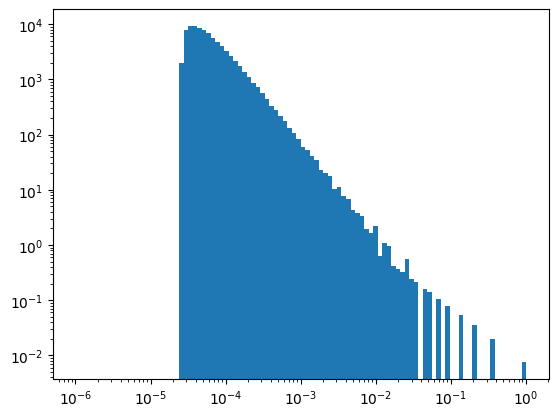

In [99]:
hist, bins = jnp.histogram(Khat_eigs[Khat_eigs > 0], bins=100)
logbins = np.logspace(-6,np.log10(bins[-1]),len(bins))
plt.hist(Khat_eigs, bins=logbins, density=True)
plt.xscale("log")
plt.yscale("log")

In [100]:
@jit
def fixed_point_iter(z,s,t):
    S_vec = 1/(1+(s/d)*D_vec)
    bSb = jnp.sum(S_vec * (btilde**2))
    u = 1/(1 + t/d)
    denom = 1-c**2/z * d * u * bSb

    s = -d/z * u - (c**2/z**2 * d * u**2 * bSb)/denom
    t = -jnp.sum(D_vec * S_vec)/z - (c**2*d/z**2 * u * jnp.sum(D_vec * S_vec**2 * btilde**2))/denom

    return s,t

@jit
def fixed_point_solve(x,ivals):
    s = 1
    t = 1
    for i in ivals:
        z = x + i*1.0j
        s,t = fixed_point_iter(z,s,t)
    S_vec = 1/(1+(s/d)*D_vec)
    bSb = jnp.sum(S_vec * (btilde**2))
    u = 1/(1 + t/d)
    denom = 1-c**2/z * d * u * bSb
    tr_R = -1/z * jnp.sum(S_vec) - (c**2/z**2 * u * jnp.sum(S_vec**2 * btilde**2))/denom
    limit_dist = 1/jnp.pi * np.imag(tr_R) / d

    return limit_dist

In [101]:
@jit
def newton_step(z,s,t):
    S_vec = 1/(1+(s/d)*D_vec)
    bSb = jnp.sum(S_vec * btilde**2)
    bDS2b = jnp.sum(D_vec * S_vec**2 * btilde**2)
    trDS = jnp.sum(D_vec * S_vec)
    trD2S2 = jnp.sum(D_vec**2 * S_vec**2)
    bD2S3b = jnp.sum(D_vec**2 * S_vec**3 * btilde**2)
    u = 1 + t/d
    denom = 1-c**2/z * d * u * bSb

    df1_ds = 1 - (c**2/z**2 * u**2 * bSb)/denom**2
    df1_dt = -u**2/z + (c**4/z**3 * d * u**4 * bSb**2 - 2*c**2/z**2 * u**3 * bSb)/denom**2
    df2_ds = -1/(z*d) * trD2S2 - (2*c**2/z**2 * u * bD2S3b * (1-c**2/z * d * u * bSb) - c**4/z**3 * d * u**2 * bDS2b**2)/denom**2
    df2_dt = 1 - (c**2/z**2 * u**2 * bDS2b)/denom**2

    J = jnp.array([[df1_ds,df1_dt],[df2_ds,df2_dt]])

    f1 = s + d/z * u + (c**2/z**2 * d * u**2 * bSb)/denom
    f2 = t + 1/z * trDS + (c**2/z**2 * d * u * bDS2b)/denom
    f = jnp.array([f1,f2])

    delta = jnp.linalg.solve(J,-f)
    s += delta[0]
    t += delta[1]

    return s,t

@jit
def newton_solve(x, ivals):
    s = 1
    t = 1
    for i in ivals:
        z = x + i*1.0j
        s,t = newton_step(z,s,t)
    S_vec = 1/(1+(s/d)*D_vec)
    bSb = jnp.sum(S_vec * (btilde**2))
    u = 1/(1 + t/d)
    denom = 1-c**2/z * d * u * bSb
    tr_R = -1/z * jnp.sum(S_vec) - (c**2/z**2 * u**2 * jnp.sum(S_vec**2 * btilde**2))/denom
    limit_dist = 1/jnp.pi * jnp.imag(tr_R) / d

    return limit_dist

In [102]:
@jit
def fixed_point_iter_m(z,m):
    m = 1/(1+1/d * jnp.sum(D_vec/(D_vec*m-z)))
    return m

def fixed_point_solve_m(x,ivals):
    m = 1
    for i in ivals:
        z = x + i*1.0j
        m = fixed_point_iter_m(z,m)
    R0 = 1/(D_vec*m-z)
    bR02b = jnp.sum(R0**2 * btilde**2)
    bR0b = jnp.sum(R0 * btilde**2)
    tr_R = jnp.sum(R0) - (c**2 * d * bR02b)/(1+c**2 * d * bR0b)
    limit_dist = 1/jnp.pi * np.imag(tr_R) / d

    return limit_dist

In [103]:
@jit
def newton_step_m(z,m):
    S_vec = D_vec / (D_vec * m - z)
    s = jnp.sum(S_vec)
    s2 = jnp.sum(S_vec ** 2)
    f = m * (1 + s/d) - 1
    f_prime = 1 + s/d - m/d * s2
    m -= f/f_prime

    return m

@jit
def newton_solve_m(x,ivals):
    m = 1
    for i in ivals:
        z = x + i*1.0j
        m = newton_step_m(z,m)
    R0 = 1/(D_vec*m-z)
    bR02b = jnp.sum(R0**2 * btilde**2)
    bR0b = jnp.sum(R0 * btilde**2)
    tr_R = jnp.sum(R0) - (c**2 * bR02b)/(1+c**2 * bR0b)
    limit_dist = 1/jnp.pi * jnp.imag(tr_R) / d

    return limit_dist

In [104]:
#Stieltjes inversion
# Next time try Newton

xvals = jnp.logspace(-6,1,num=1000)
ivals = jnp.logspace(0,-10,num=100)

limit_dist = []

for x in xvals:
   limit_dist.append(newton_solve_m(x,ivals).reshape(-1))

limit_dist = jnp.array(limit_dist)

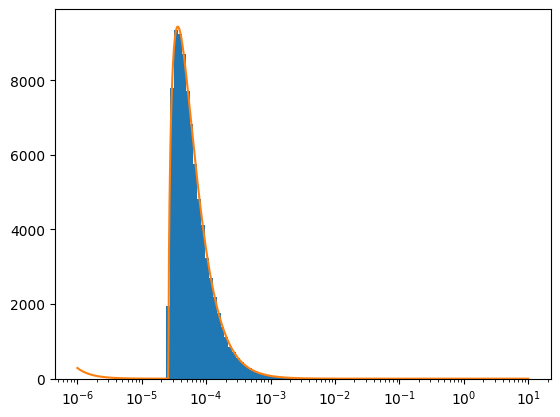

In [105]:
hist, bins = jnp.histogram(Khat_eigs, bins=100)
logbins = np.logspace(-6,np.log10(bins[-1]),len(bins))
plt.hist(Khat_eigs, bins=logbins, density=True)
plt.plot(xvals, limit_dist)
plt.xscale('log')
#plt.yscale('log')

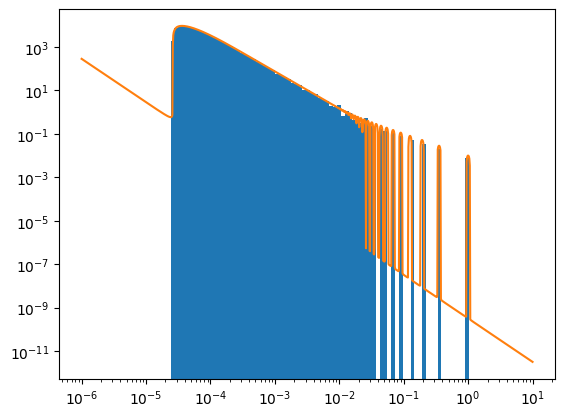

In [106]:
hist, bins = jnp.histogram(Khat_eigs, bins=100)
logbins = np.logspace(-6,np.log10(bins[-1]),len(bins))
plt.hist(Khat_eigs, bins=logbins, density=True)
plt.plot(xvals, limit_dist)
plt.xscale('log')
plt.yscale('log')

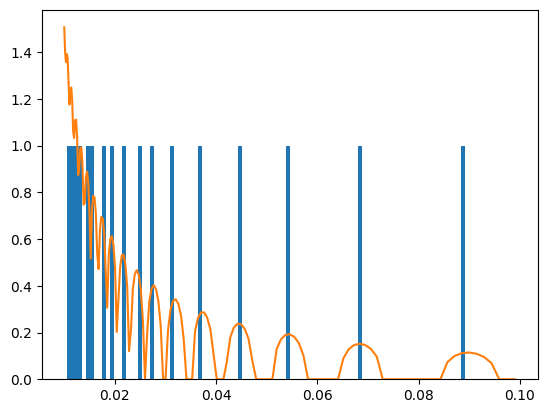

In [107]:
plt.hist(Khat_eigs[(Khat_eigs > 1e-2) * (Khat_eigs < 1e-1)], bins=100)
plt.plot(xvals[(xvals > 1e-2) * (xvals < 1e-1)], limit_dist[(xvals > 1e-2) * (xvals < 1e-1)])